# Data Preparation

In [1]:
# import library used for data management
import numpy as np 
import pandas as pd 

In [2]:
# load datasets
hotel = pd.read_csv('hotel_bookings.csv')
#label = pd.read_csv('label_hotel_bookings.csv')

## Sharon's part

In [3]:
# change 'is_repeated_guest' to categorical
hotel['is_repeated_guest']=hotel['is_repeated_guest'].astype(str)

# handle missing values in 'agent'
# NaN in 'agent' means the booking is not made by a travel agency
# replace NaN with 0 for the ease of data handling
hotel['agent'].fillna(0,inplace=True)

In [4]:
# change 'agent' to categorical
#hotel['agent'] = hotel['agent'].astype(str)
#hotel['agent'].describe()

In [5]:
# get dummy variables for categorical variable 'deposit_type'
DepositTypeDummy = pd.get_dummies(hotel['deposit_type'],prefix='deposit_type')
# Adding the dummy variables to the data frame
hotel = pd.concat([hotel,DepositTypeDummy],axis=1,sort=True)

# 'deposit_type_Refundable' could be expressed as not 'deposit_type_No Deposit' and not 'deposit_type_Non Refund'
hotel = hotel.drop(columns=['deposit_type','deposit_type_Refundable'])

# Hypothesis: If reserved room type matches assigned room type, i.e. reserved_assigned_room_type_match = 1, it is more likely for the customer to NOT cancel the booking.
# check to see if reserved room type matches assigned room type
hotel['reserved_assigned_room_type_match'] = (hotel['reserved_room_type'] == hotel['assigned_room_type'])
# convert to result to 0 and 1, categorical
hotel['reserved_assigned_room_type_match'] = hotel['reserved_assigned_room_type_match'].astype(int)
hotel['reserved_assigned_room_type_match'] = hotel['reserved_assigned_room_type_match'].astype(str)
# 'reserved_room_type' and'assigned_room_type' expressed by 'reserved_assigned_room_type_match'
#original = original.drop(columns=['reserved_room_type','assigned_room_type'])

In [6]:
# Binning

# Put previous_cancellations into 4 categories
cut_labels_4 = ['0','1-10', '11-20', '21+']
cut_bins = [0, 0.1, 10, 20, 30]
hotel['cut_previous_cancellations'] = pd.cut(hotel['previous_cancellations'], include_lowest=True, bins=cut_bins, labels=cut_labels_4)
hotel.groupby('cut_previous_cancellations')['is_canceled'].value_counts()

# Put previous_bookings_not_canceled into 5 categories
cut_labels_5 = ['0','1-20', '21-40', '41-60', '60+']
cut_bins_previous_bookings_not_canceled = [0, 0.1, 20, 40, 60, 81]
hotel['cut_previous_bookings_not_canceled'] = pd.cut(hotel['previous_bookings_not_canceled'], include_lowest=True, bins=cut_bins_previous_bookings_not_canceled, labels=cut_labels_5)
hotel.groupby('cut_previous_bookings_not_canceled')['is_canceled'].value_counts()

# Put booking_changes into 6 categories
cut_labels_6 = ['0','1-5', '6-10', '11-15', '16-20','21+']
cut_bins_booking_changes = [0, 0.1, 5, 10, 15, 20, 26]
hotel['cut_booking_changes'] = pd.cut(hotel['booking_changes'], bins=cut_bins_booking_changes, include_lowest=True, labels=cut_labels_6)
hotel.groupby('cut_booking_changes')['is_canceled'].value_counts()

cut_booking_changes  is_canceled
0                    0              59923
                     1              41391
1-5                  0              15123
                     1               2804
6-10                 0                 98
                     1                 27
11-15                0                 16
                     1                  1
16-20                0                  5
                     1                  1
21+                  0                  1
Name: is_canceled, dtype: int64

In [7]:
# feature - agent
hotel.groupby('is_canceled')['agent'].value_counts()

# Groupby is_canceled and find the most frequent agent for each is_canceled
hotel.groupby('is_canceled')['agent'].agg(pd.Series.mode)

# Groupby agent and find how many cancelled and not cancelled each agent has
hotelAgentCount = hotel.groupby(['agent','is_canceled'])['is_canceled'].size().reset_index(name='count_cancelled')
hotelAgentSum = hotel.groupby('agent')['is_canceled'].count().reset_index(name='sum')
# left join the sum and count
hotelAgentJoined= hotelAgentCount.merge(hotelAgentSum, on='agent', how='left')

# finding the percentage of each label in an agent
hotelAgentJoined['percentage'] = hotelAgentJoined.apply(lambda x: x['count_cancelled']/x['sum'], axis=1)

# all agents whose majority label is more than 80% and sum is more than 1000
hotelAgentJoined80 = hotelAgentJoined[hotelAgentJoined['percentage'] > 0.8]
hotelAgentJoined3000= hotelAgentJoined80[hotelAgentJoined80['sum'] > 3000]

# agent 7 and 14 are the most predictive agents so they would be the dummy variables
hotel['agent_14'] = hotel['agent'].apply(lambda x: 1 if x == '14.0' else 0)
hotel['agent_7'] = hotel['agent'].apply(lambda x: 1 if x == '7.0' else 0)
hotel['agent_is_other'] = hotel['agent'].apply(lambda x: 1 if (x != '14.0' and x!='7.0') else 0)

In [8]:
# cut_previous_cancellations represented previous_cancellations in categorical format -> drop previous_cancellations
# cut_previous_bookings_not_canceled represented previous_bookings_not_canceled in categorical format -> drop previous_bookings_not_canceled
# cut_booking_changes represented booking_changes in categorical format -> drop booking_changes
# agent_14, agent_7 & agent_is_other represented agent (keep agent for the time being)

In [9]:
hotel = hotel.drop(columns=['previous_cancellations','previous_bookings_not_canceled','booking_changes'])
hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reservation_status_date,deposit_type_No Deposit,deposit_type_Non Refund,reserved_assigned_room_type_match,cut_previous_cancellations,cut_previous_bookings_not_canceled,cut_booking_changes,agent_14,agent_7,agent_is_other
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,2015-07-01,1,0,1,0,0,1-5,0,0,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,2015-07-01,1,0,1,0,0,1-5,0,0,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,2015-07-02,1,0,0,0,0,0,0,0,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,2015-07-02,1,0,1,0,0,0,0,0,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,2015-07-03,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,2017-09-06,1,0,1,0,0,0,0,0,1
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,2017-09-07,1,0,1,0,0,0,0,0,1
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,2017-09-07,1,0,1,0,0,0,0,0,1
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,2017-09-07,1,0,1,0,0,0,0,0,1


## Leo's part

In [10]:
from sklearn import preprocessing

# company, reservation_status, reservation_status_date directly drop
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['days_in_waiting_list']])
hotel['days_in_waiting_list_minmax']=minmax_scaler.transform(hotel[['days_in_waiting_list']])

custypedummy = pd.get_dummies(hotel['customer_type'],prefix ='customer_type')

hotel['adr'].describe()
mean_adr=hotel['adr'].mean()
std_adr=hotel['adr'].std()
a = np.array(hotel['adr'].values.tolist())
hotel['adr'] = np.where(a > (mean_adr+10*std_adr), mean_adr, a).tolist() # delete outlier
minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['adr']])
hotel['adr_minmax']=minmax_scaler.transform(hotel[['adr']])

minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['required_car_parking_spaces']])
hotel['required_car_parking_spaces_minmax']=minmax_scaler.transform(hotel[['required_car_parking_spaces']])

minmax_scaler = preprocessing.MinMaxScaler().fit(hotel[['total_of_special_requests']])
hotel['total_of_special_requests_minmax']=minmax_scaler.transform(hotel[['total_of_special_requests']])

hotel=hotel.drop(columns=['company','days_in_waiting_list','customer_type','adr','required_car_parking_spaces', 'total_of_special_requests','reservation_status','reservation_status_date'])

hotel = pd.concat([hotel,custypedummy],axis=1,sort=True)

hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent_7,agent_is_other,days_in_waiting_list_minmax,adr_minmax,required_car_parking_spaces_minmax,total_of_special_requests_minmax,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,1,0.0,0.012355,0.0,0.0,0,0,1,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,1,0.0,0.012355,0.0,0.0,0,0,1,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,1,0.0,0.157597,0.0,0.0,0,0,1,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,1,0.0,0.157597,0.0,0.0,0,0,1,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,1,0.0,0.202138,0.0,0.2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,1,0.0,0.198536,0.0,0.0,0,0,1,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,1,0.0,0.448914,0.0,0.4,0,0,1,0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,1,0.0,0.317770,0.0,0.8,0,0,1,0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,1,0.0,0.214532,0.0,0.0,0,0,1,0


In [11]:
hotel.to_csv("Leo_Sharon_processeddata.csv")

# Data Visualization

In [12]:
hotel.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,agent_7,agent_is_other,days_in_waiting_list_minmax,adr_minmax,required_car_parking_spaces_minmax,total_of_special_requests_minmax,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.0,119390.0,119390.000000,119390.000000,119390.000000,119390.000000,119390.00000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.0,1.0,0.005936,0.209471,0.007815,0.114273,0.03414,0.004833,0.750591,0.210436
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.0,0.0,0.044999,0.093252,0.030661,0.158560,0.18159,0.069351,0.432673,0.407620
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.0,1.0,0.000000,0.146539,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.0,1.0,0.000000,0.195505,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.0,1.0,0.000000,0.256362,0.000000,0.200000,0.00000,0.000000,1.000000,0.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (16,8))
sns.set(style='darkgrid')

<Figure size 1152x576 with 0 Axes>

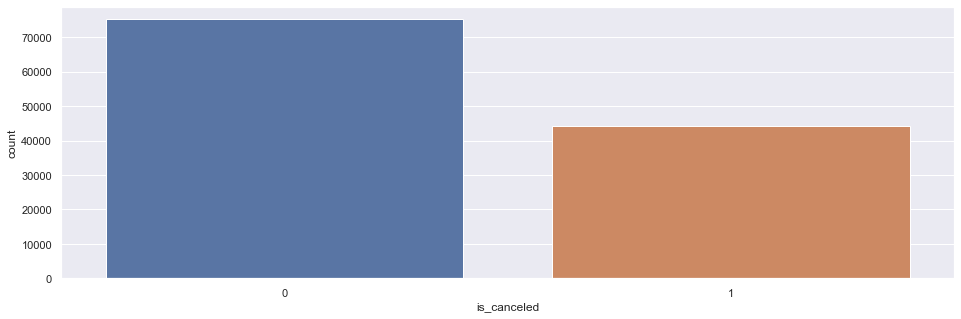

In [14]:
# label - is_canceled
plt.figure(figsize = (16,5))
sns.countplot(hotel['is_canceled'])

is_repeated_guest  is_canceled
0                  0              71908
                   1              43672
1                  0               3258
                   1                552
Name: is_canceled, dtype: int64


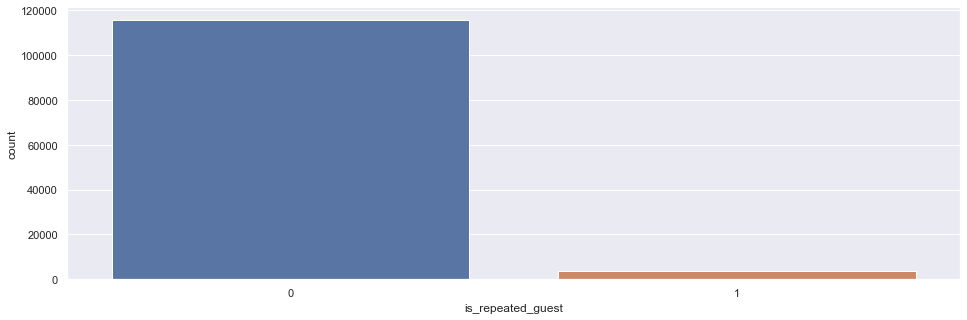

In [15]:
# feature - is_repeated_guest
print(hotel.groupby('is_repeated_guest')['is_canceled'].value_counts())
plt.figure(figsize = (16,5))
sns.countplot(hotel['is_repeated_guest'])
## The majority of guests is not repeated guest, we need to know if this feature has strong relationship with the label.

In [16]:
# feature - previous_cancellations: long tail
hotel.groupby('cut_previous_cancellations')['is_canceled'].value_counts()

cut_previous_cancellations  is_canceled
0                           0              74624
                            1              38282
1-10                        1               5788
                            0                516
11-20                       1                 54
                            0                 26
21+                         1                100
Name: is_canceled, dtype: int64

In [17]:
hotel['cut_previous_cancellations']

0         0
1         0
2         0
3         0
4         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: cut_previous_cancellations, Length: 119390, dtype: category
Categories (4, object): [0 < 1-10 < 11-20 < 21+]

In [18]:
# feature - previous_bookings_not_canceled: long tail
hotel.groupby('cut_previous_bookings_not_canceled')['is_canceled'].value_counts()

cut_previous_bookings_not_canceled  is_canceled
0                                   0              71746
                                    1              44024
1-20                                0               3300
                                    1                185
21-40                               0                 88
                                    1                 12
41-60                               0                 20
                                    1                  3
60+                                 0                 12
Name: is_canceled, dtype: int64

In [19]:
# feature - booking_changes: long tail
hotel.groupby('cut_booking_changes')['is_canceled'].value_counts()

cut_booking_changes  is_canceled
0                    0              59923
                     1              41391
1-5                  0              15123
                     1               2804
6-10                 0                 98
                     1                 27
11-15                0                 16
                     1                  1
16-20                0                  5
                     1                  1
21+                  0                  1
Name: is_canceled, dtype: int64

In [20]:
# feature - agent
hotel.groupby('is_canceled')['agent'].value_counts()

is_canceled  agent
0            9.0      18697
             0.0      12310
             240.0     8438
             7.0       3065
             14.0      2988
                      ...  
1            472.0        1
             481.0        1
             483.0        1
             484.0        1
             526.0        1
Name: agent, Length: 533, dtype: int64

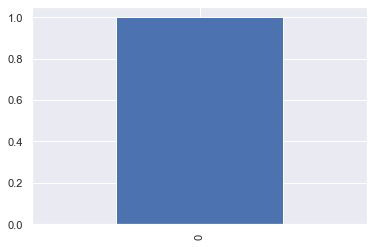

In [21]:
hotel['agent_14'].value_counts(normalize=True).plot(kind='bar')

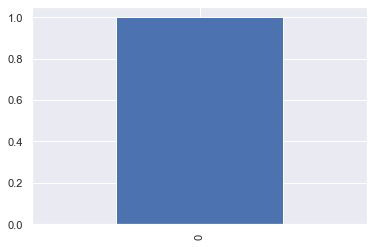

In [22]:
hotel['agent_7'].value_counts(normalize=True).plot(kind='bar')

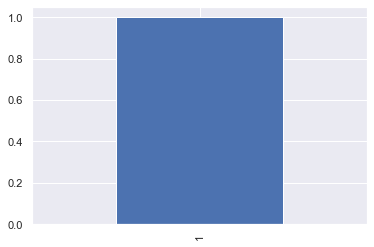

In [23]:
hotel['agent_is_other'].value_counts(normalize=True).plot(kind='bar')

In [24]:
# features - deposit_type_No Deposit & deposit_type_Non Refund
hotel.groupby('deposit_type_No Deposit')['deposit_type_Non Refund'].value_counts()
# 00 = deposit_type_Refundable
# 01 = deposit_type_Non Refund
# 10 = deposit_type_No Deposit

deposit_type_No Deposit  deposit_type_Non Refund
0                        1                           14587
                         0                             162
1                        0                          104641
Name: deposit_type_Non Refund, dtype: int64

In [25]:
# feature - reserved_assigned_room_type_match
hotel.groupby('reserved_assigned_room_type_match')['is_canceled'].value_counts()

reserved_assigned_room_type_match  is_canceled
0                                  0              14115
                                   1                802
1                                  0              61051
                                   1              43422
Name: is_canceled, dtype: int64

In [26]:
hotel

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent_7,agent_is_other,days_in_waiting_list_minmax,adr_minmax,required_car_parking_spaces_minmax,total_of_special_requests_minmax,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,1,0.0,0.012355,0.0,0.0,0,0,1,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,1,0.0,0.012355,0.0,0.0,0,0,1,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,1,0.0,0.157597,0.0,0.0,0,0,1,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,1,0.0,0.157597,0.0,0.0,0,0,1,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,1,0.0,0.202138,0.0,0.2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,1,0.0,0.198536,0.0,0.0,0,0,1,0
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,1,0.0,0.448914,0.0,0.4,0,0,1,0
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,1,0.0,0.317770,0.0,0.8,0,0,1,0
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,1,0.0,0.214532,0.0,0.0,0,0,1,0
